# OBJVAE

## Init

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random, os
import numpy as np
import torch
import importlib
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE import objVAE, MultiheadAttention
from objVAE import bg
from objVAE import utils

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

2023-11-28 09:15:55.752166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 09:15:57.603981: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

### Helper functions

In [2]:
def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            attention,
        ) = model(x)
        alpha = z_pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(z_pres[0, alpha].detach().cpu().numpy())

    else:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            attention,
        ) = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 3)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], s=10, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    plt.subplot(2, 2, 1)
    plt.imshow(
        background[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("background")

    plt.subplot(2, 2, 2)
    plt.imshow(
        x_hat[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("forground")

    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

## Run/Test

### Load data

(3000, 81, 128)
torch.Size([600, 5, 1, 81, 128])


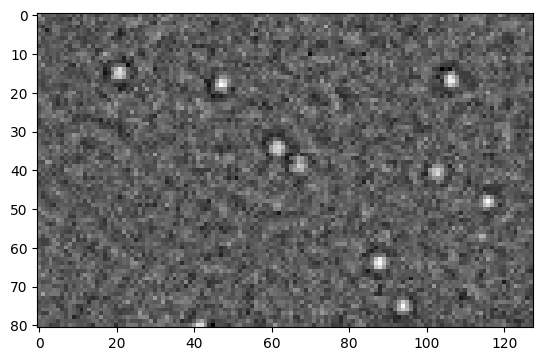

In [3]:
import tifffile

path = r'/data/mp_mpa/simulated/Sim_results_Low.tiff'

images = tifffile.imread(path, key=range(300, 12300, 4))
print(images.shape)

images = np.abs((images-np.min(images))/(np.max(images)-np.min(images)) - 1)
images = np.split(images, 600, axis=0)
training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(1, 2, 3), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=2)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[8,2,:,:,:]), cmap='gray')

In [4]:
train, test = torch.utils.data.random_split(training_images, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(training_images, batch_size=1, shuffle=False)

### Create model

In [5]:
import IPython.display as ipd
import pytorch_lightning as pl

# Callbacks
max_steps = 20000
beta_annealing_end = max_steps
lr_annealing_end = max_steps
kl_annealing_end = 2400
presence_annealing_end = 2500
unfreeze = 0

def beta_annealing(step):
    logs = np.logspace(-8, -3, beta_annealing_end) # 8.3 - 7
    if step < unfreeze:
        return logs[0]
    if step < beta_annealing_end:
        return logs[int(step)-unfreeze]
    else:
        return logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < kl_annealing_end*0.5:
        return 0
    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1

def presence_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def unfreeze_foreground(step):
    for param in model.model.parameters():
        param.requires_grad = True



class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)

class UnfreezeCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == 100:
            unfreeze_foreground(model)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 2:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [17]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

load_model = ""

#load_model = "../state_dicts/model-musc-bg.pth"
#load_model = "../state_dicts/model-microtubuler-256px-bad.pth"


use_attention = False
num_entities = 25
softmax_tmp = 1
latent_dim = 5
beta = 1e-4
number_of_heads = 1
object_radius = 8
combine_method = "sum"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers=1
decoder_num_layers=10

single_decoder = True
attention_mechanism='cosine-similarity'

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

background_model = bg.objBG(in_channels=1,image_size=128, **bg_params)
    

attention = MultiheadAttention.MultiheadAttention(
    max_t=1, attention_mechanism=attention_mechanism, softmax_factor=softmax_tmp, number_of_heads=1, num_filters=latent_dim-2
)
model = objVAE.MEVAE(
    num_entities,
    attention_model=attention,
    background_model=background_model,
    beta=beta,
    latent_dim=latent_dim,
    attention=use_attention,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))

for param in model.model.parameters():
    param.requires_grad = False


In [18]:
for param in model.model.parameters():
    param.requires_grad = True

### Train

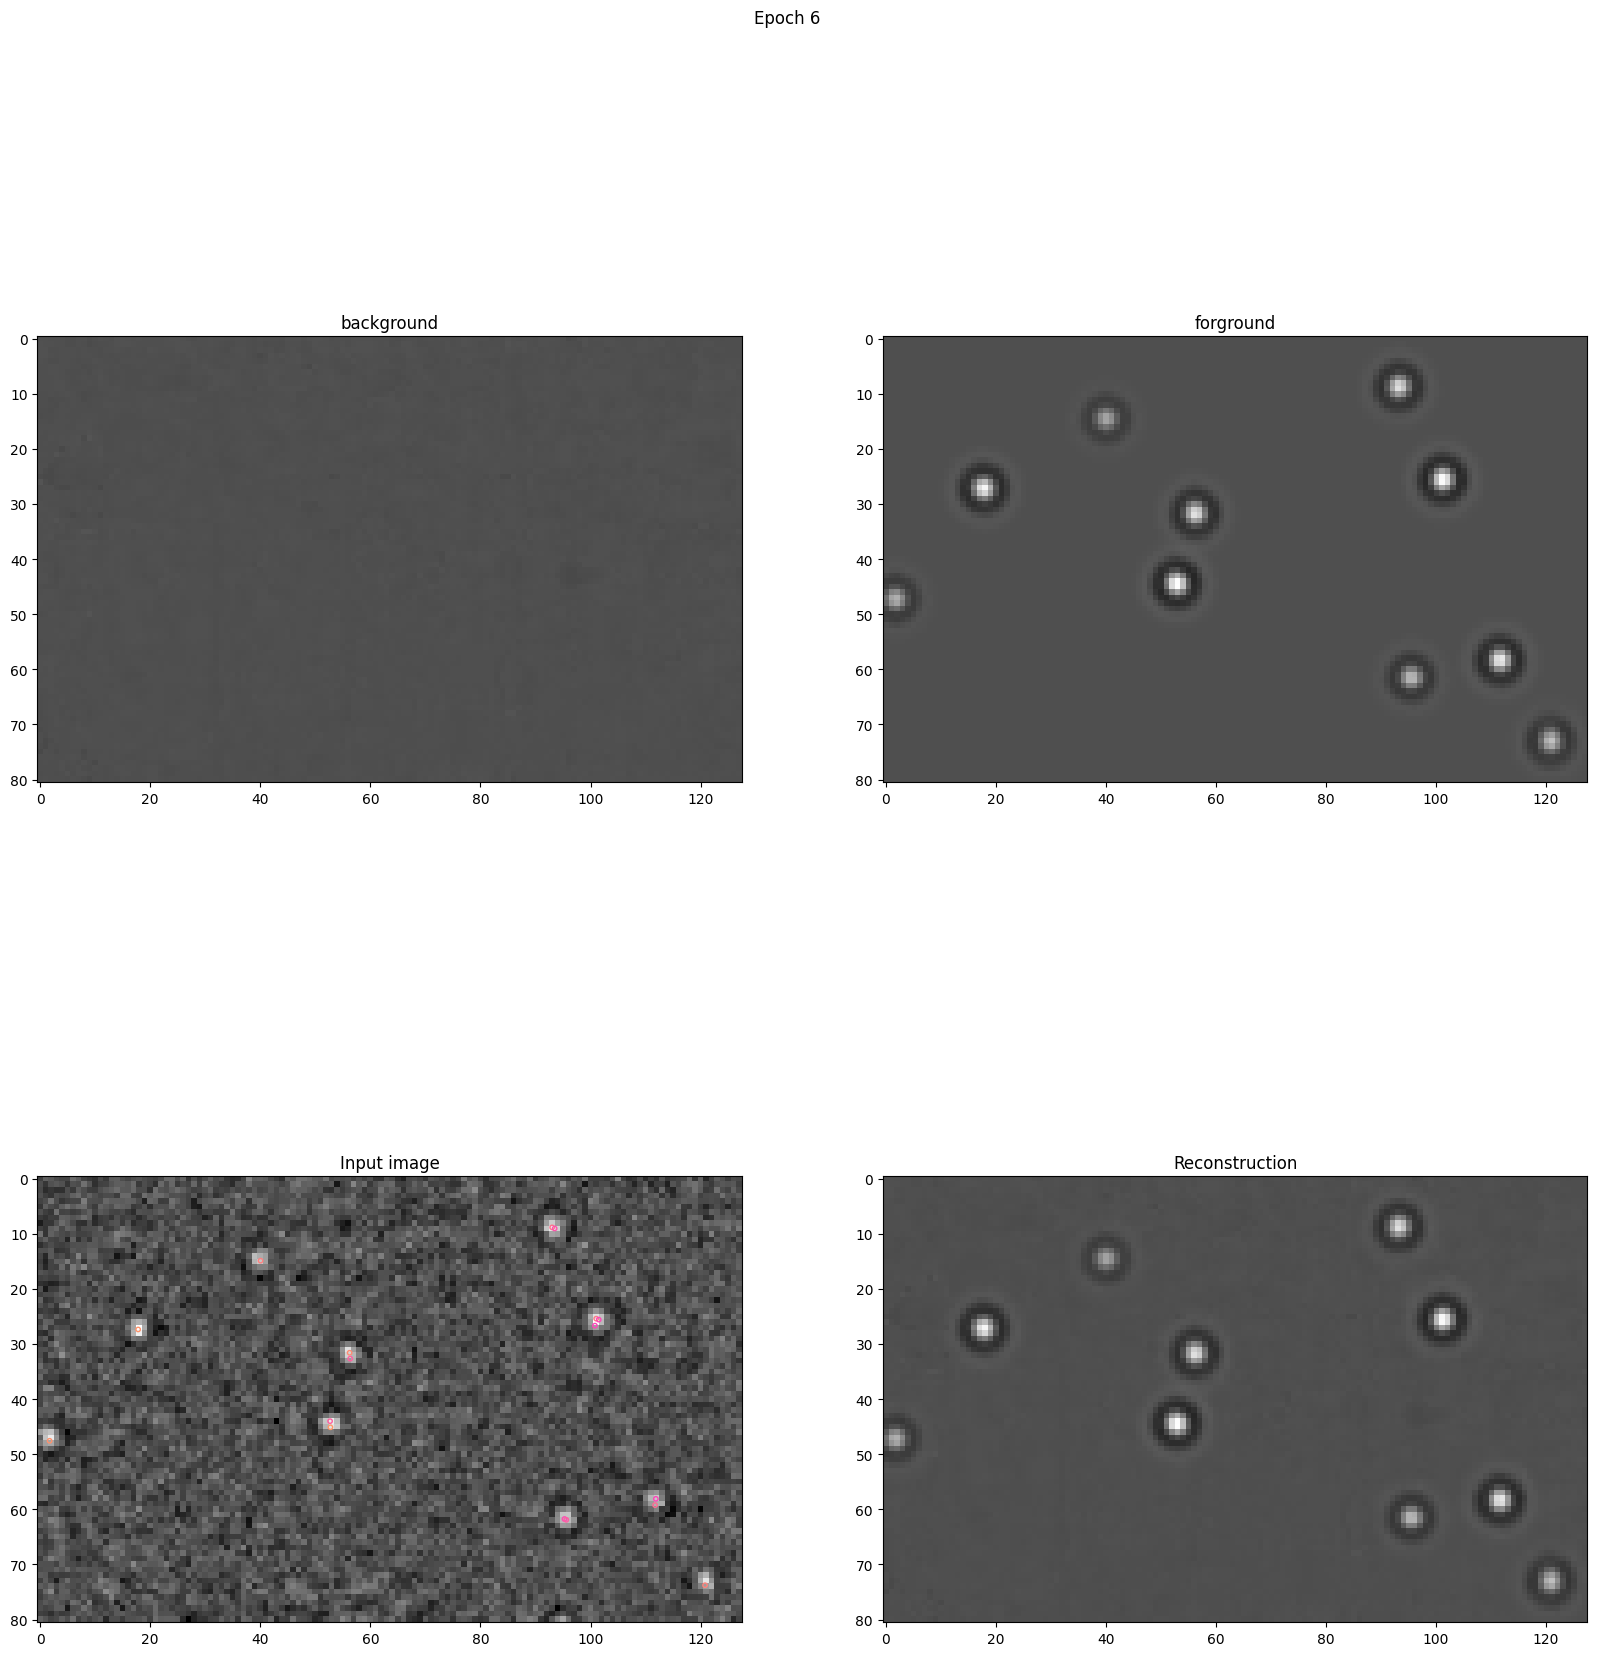

Epoch 7:  94%|█████████▍| 225/240 [00:04<00:00, 45.39it/s, v_num=2039, loss_step=0.0897, recon_loss_step=0.0897, kl_loss_step=20.20, kl_for_step=16.90, kl_back_step=3.220, loss_epoch=0.0882, recon_loss_epoch=0.0882, kl_loss_epoch=19.20, kl_for_epoch=16.20, kl_back_epoch=2.990]

In [19]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

### Test

...........
{'x': [37.187996], 'y': [50.6229], 'code': [-1], 'start': 0, 'end': 0}
{'x': [35.560825], 'y': [4.7093782], 'code': [-1], 'start': 0, 'end': 0}
{'x': [51.22386], 'y': [84.97709], 'code': [-1], 'start': 0, 'end': 0}
{'x': [55.808727], 'y': [101.05444], 'code': [-1], 'start': 0, 'end': 0}
{'x': [66.02497], 'y': [14.156791], 'code': [-1], 'start': 0, 'end': 0}
{'x': [45.15374], 'y': [24.181276], 'code': [-1], 'start': 0, 'end': 0}
{'x': [4.715609], 'y': [22.18953], 'code': [-1], 'start': 0, 'end': 0}
{'x': [23.229893], 'y': [10.696551], 'code': [-1], 'start': 0, 'end': 0}
{'x': [27.364447], 'y': [28.959673], 'code': [-1], 'start': 0, 'end': 0}
{'x': [57.97416], 'y': [51.979958], 'code': [-1], 'start': 0, 'end': 0}
{'x': [26.96539], 'y': [110.64744], 'code': [-1], 'start': 0, 'end': 0}
{'x': [71.93918], 'y': [11.610709], 'code': [-1], 'start': 0, 'end': 0}


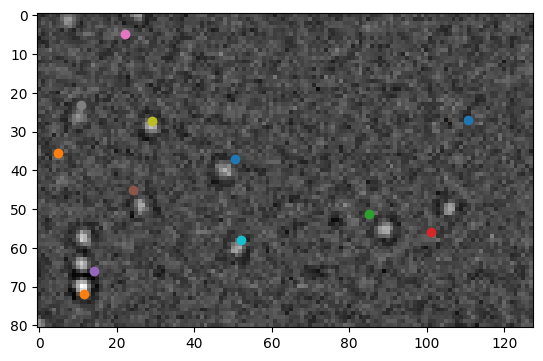

In [20]:
seq = test[0]

tra_list = model.extract_obj_and_tra(seq, 4, presence_floor=0.25, tra_floor=49)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

In [26]:
print(model.model.kl_importance)
model.model.kl_importance = 1

0


In [27]:
utils.run_test(
    training_images,
    model,
    combine_radius=2,
    plot_num=None,
    num_entities=25,
    pres_floor=0.25,
    tra_floor=0.99,
    )

/workspace/aa-attention/objVAE/objVAE/utils.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


### Save model

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-MP-firstworking.pth")